In [ ]:
import csv
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.metrics import mean_squared_error

In [ ]:
import pyodbc 

server = '192.168.1.44' 
database = 'EKG_patients' 
username = 'Read_only_public' 
password = 'rop' 

cnxn = pyodbc.connect('Driver={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

cursor.execute('SELECT * FROM ECG_8_AVR')
data_AVR = np.array(cursor.fetchall())
data_AVR = data_AVR.astype('float64')
#data_AVR = data_AVR - data_AVR.mean()    #already normalized

cursor.execute('SELECT * FROM ECG_8_II')
data_II = np.array(cursor.fetchall())
data_II = data_II.astype('float64')

cursor.execute('SELECT * FROM ECG_8_V')
data_V = np.array(cursor.fetchall())
data_V = data_V.astype('float64')
#data_V = data_V - data_V.mean()    #already normalized

cursor.execute('SELECT * FROM ECG_8_II_missing')
data_II_missing = np.array(cursor.fetchall())
data_II_missing = data_II_missing.astype('float64')

In [ ]:
train_feature_I = data_AVR[0:data_AVR.size-3750]
train_feature_II = data_V[0:data_AVR.size-3750]
train_label = data_II  

class_names = ['feature_I', 'feature_II', 'label']

In [4]:
# train label
my_train_label = np.c_[train_label]
my_train_label = my_train_label.astype('float64')
class_names = ['label']
df_train_label = pd.DataFrame(data=my_train_label, columns=class_names)

# train features
my_train_features = np.c_[train_feature_I,train_feature_II]
my_train_features = my_train_features.astype('float64')
class_names = ['feature_I', 'feature_II']
df_train_features = pd.DataFrame(data=my_train_features, columns=class_names)

In [5]:
def build_model():
  model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=(0,2)),
    layers.Dense(12, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

In [6]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 0, 12)             36        
_________________________________________________________________
dense_1 (Dense)              (None, 0, 12)             156       
_________________________________________________________________
dense_2 (Dense)              (None, 0, 12)             156       
_________________________________________________________________
dense_3 (Dense)              (None, 0, 1)              13        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [7]:
EPOCHS = 500

history = model.fit(
  my_train_features, my_train_label,
  epochs=EPOCHS, validation_split = 0.001, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0042,  mae:0.0292,  mse:0.0042,  val_loss:0.0000,  val_mae:0.0051,  val_mse:0.0000,  
....................................................................................................
Epoch: 100, loss:0.0000,  mae:0.0052,  mse:0.0000,  val_loss:0.0001,  val_mae:0.0101,  val_mse:0.0001,  
....................................................................................................
Epoch: 200, loss:0.0000,  mae:0.0051,  mse:0.0000,  val_loss:0.0001,  val_mae:0.0061,  val_mse:0.0001,  
....................................................................................................
Epoch: 300, loss:0.0000,  mae:0.0050,  mse:0.0000,  val_loss:0.0000,  val_mae:0.0048,  val_mse:0.0000,  
....................................................................................................
Epoch: 400, loss:0.0000,  mae:0.0049,  mse:0.0000,  val_loss:0.0000,  val_mae:0.0049,  val_mse:0.0000,  
........................................................................

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.000041,0.004911,0.000041,0.000061,0.005386,0.000061,495
496,0.000041,0.004937,0.000041,0.000062,0.006030,0.000062,496
497,0.000041,0.004914,0.000041,0.000041,0.004860,0.000041,497
498,0.000040,0.004906,0.000040,0.000040,0.004718,0.000040,498
499,0.000040,0.004907,0.000040,0.000053,0.005189,0.000053,499


In [9]:
test_feature_I = data_AVR[data_AVR.size-3749:data_AVR.size]   #test_feature_I.size    3749
test_feature_II = data_V[data_AVR.size-3749:data_AVR.size]    #test_feature_II.size   3749
test_label = data_II_missing                                  #test_label.size        3749

# test features
my_test_features = np.c_[test_feature_I,test_feature_II]    #3749
my_test_features = my_test_features.astype('float64')
class_names = ['feature_I', 'feature_II']
df_test_features = pd.DataFrame(data=my_test_features, columns=class_names)

# test label
my_test_label = np.c_[test_label]     #3749
my_test_label = my_test_label.astype('float64')
class_names = ['label']
df_test_label = pd.DataFrame(data=my_test_label, columns=class_names)

In [10]:
test_predictions = model.predict(my_test_features).flatten()

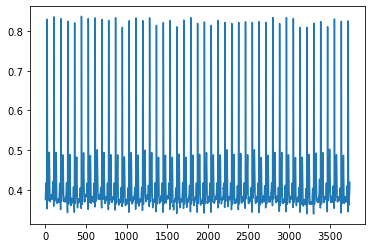

In [11]:
plt.plot(test_predictions)

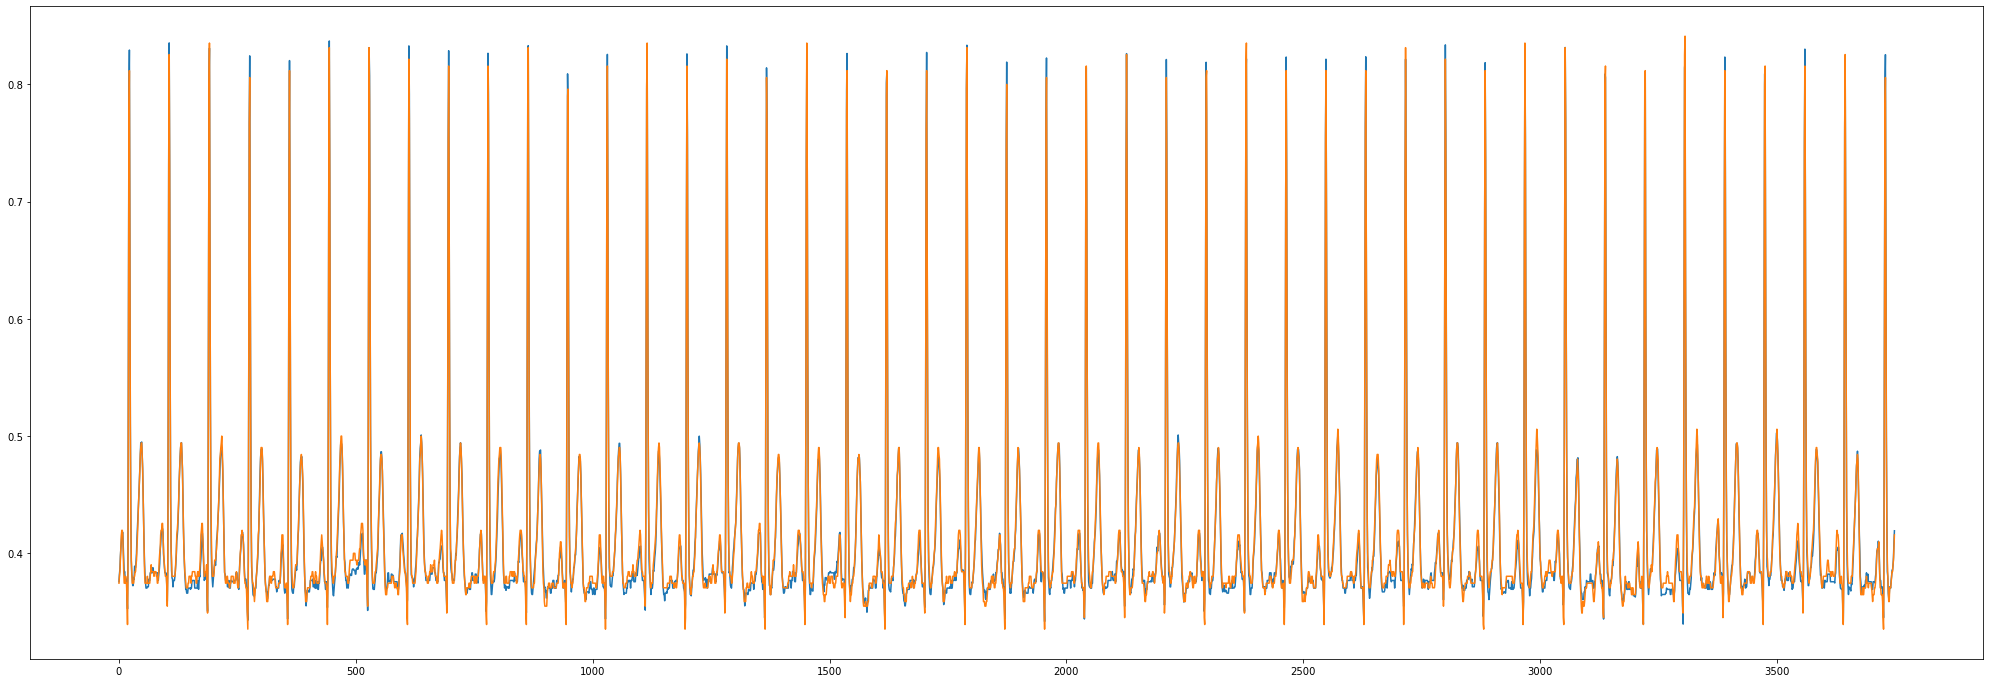

In [12]:
plt.figure(figsize=(35,12)) #(35,12)
#plt.ylim([-0.1, 0.4])
#plt.xlim([3500, 3750])
plt.plot(test_predictions)
plt.plot(my_test_label)
plt.savefig('foo.png', bbox_inches='tight')

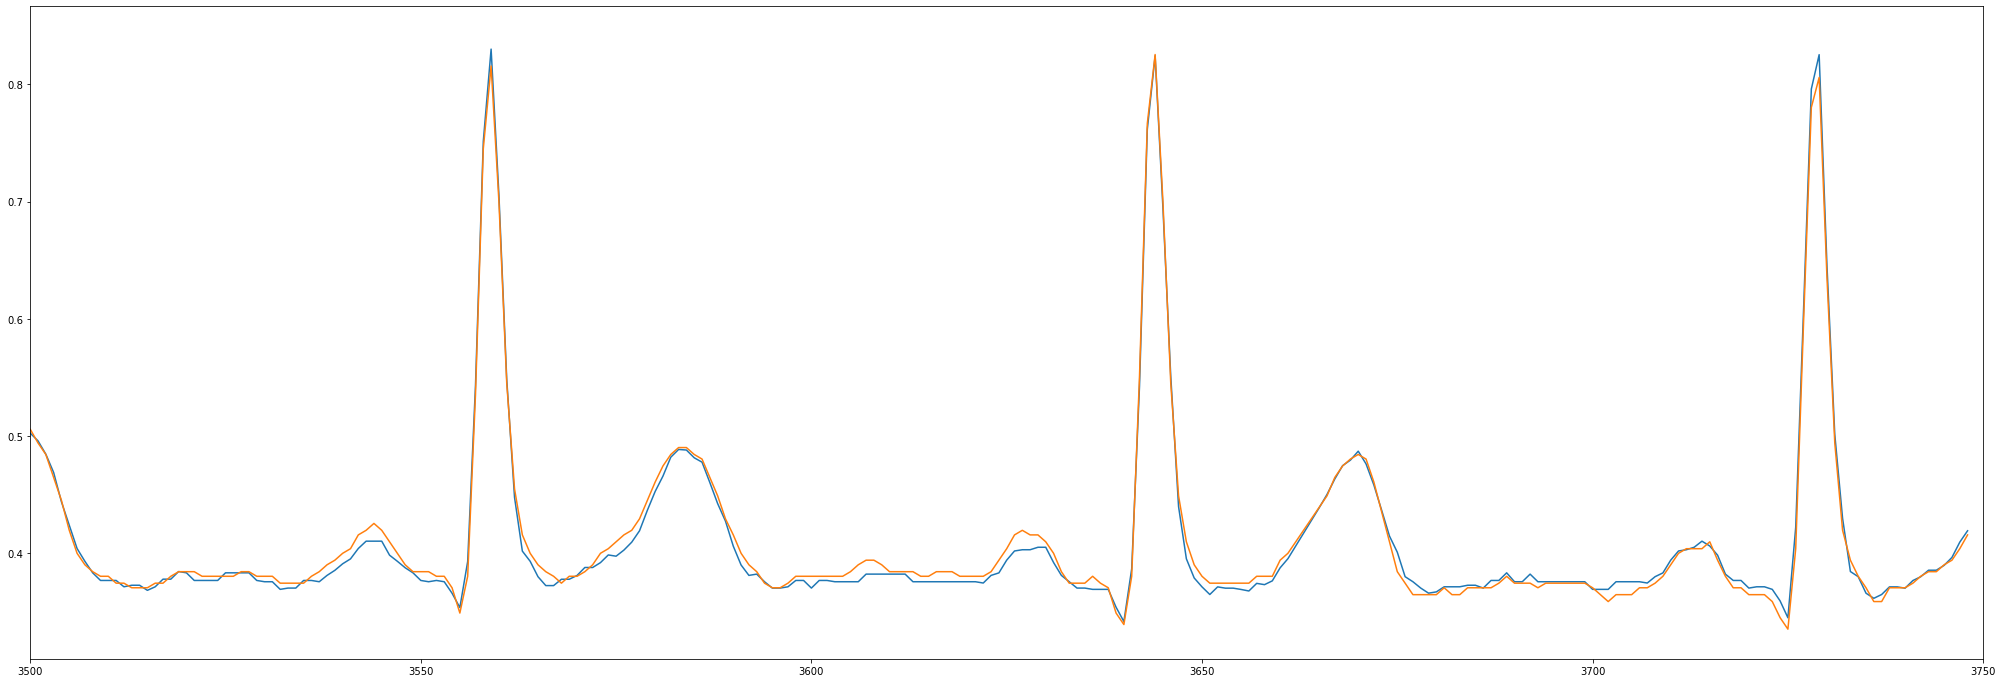

In [13]:
plt.figure(figsize=(35,12)) #(35,12)
#plt.ylim([-0.1, 0.4])
plt.xlim([3500, 3750])
plt.plot(test_predictions)
plt.plot(my_test_label)
plt.savefig('foo.png', bbox_inches='tight')

In [14]:
mse = mean_squared_error(test_predictions,my_test_label)
print(mse)

3.659819768507329e-05
